In [ ]:
import tensorflow

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from keras.layers import Flatten,MaxPooling2D,Dropout

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount("/content/drive/")

Tensorflow-version: 2.8.0
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%tensorflow_version 2.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.1758373719999327
GPU (s):
0.050834230999953434
GPU speedup over CPU: 62x


# **Accessing the Dataset**

In [ ]:
os.getcwd()
os.chdir("/content/drive/My Drive/Food-11 image dataset/")
target_labels = ["Bread", 
                 "Dairy product", 
                 "Dessert", 
                 "Egg", 
                 "Fried food", 
                 "Meat", 
                 "Noodles-Pasta", 
                 "Rice", 
                 "Seafood", 
                 "Soup", 
                 "Vegetable-Fruit"]
path = "/content/drive/My Drive/Food-11 image dataset/"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.applications import inception_v3

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=inception_v3.preprocess_input
        )

validate_datagen = ImageDataGenerator( preprocessing_function = inception_v3.preprocess_input
                                      )

test_datagen = ImageDataGenerator(
    preprocessing_function= inception_v3.preprocess_input
    )

In [ ]:
BATCH_SIZE=64

In [ ]:
train_generator = train_datagen.flow_from_directory(path+"training",
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validate_generator = validate_datagen.flow_from_directory(path+"validation",
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(path+"evaluation",
                                             target_size=(299, 299),
                                             class_mode=None,
                                             classes= target_labels,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=42)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


# **InceptionV3**

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import AveragePooling2D, Dropout, Dense, Flatten
from keras.models import Model

In [ ]:
n_classes = 11

In [ ]:
basemodel = InceptionV3(
    weights='imagenet', 
    include_top=False,
    input_shape=(299,299,3)
)

In [ ]:
basemodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_138 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_138[0][0]']             
 ormalization)                  )                                                      

In [ ]:
for layer in basemodel.layers:
	layer.trainable = False

In [ ]:
x = basemodel.output 

In [ ]:
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)

In [ ]:
predictions = Dense(n_classes, activation='softmax')(x) 

In [ ]:

model = Model(inputs=basemodel.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_138 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_138[0][0]']             
 ormalization)                  )                                                           

 Define Learning Rate

In [ ]:
def step_decay(epoch):
    initial_lr = 1e-2 
    
    if epoch < 9: 
        return initial_lr
    else: 
        return 0.00008 

In [ ]:
import matplotlib.pyplot as plt                        
%matplotlib inline  

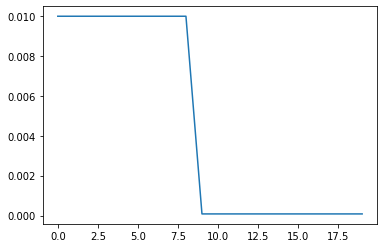

In [ ]:
x = [i for i in range(20)]
y = [step_decay(i) for i in range(20)]
plt.plot(x, y)

# **Compile the model**

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.metrics import top_k_categorical_accuracy
import math

In [ ]:
# optimizer 
opt = Adam(learning_rate=.01)

# add LearningRateScheduler to update it
lr_scheduler = LearningRateScheduler(step_decay)

# calculate top_5_accuracy to evalute the model 
def top_5_accuracy(y_true, y_pred): 
    return top_k_categorical_accuracy(y_true, y_pred, k=5)


In [ ]:
# putting them together and compile the model 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=.01)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 10,
    restore_best_weights = True,
)

In [ ]:
from keras.callbacks import ModelCheckpoint  

model_file = ('/content/drive/My Drive/Food-11 image dataset/MODEL_INCEPTIONV3-{epoch:02d}-{val_accuracy:.2f}.hdf5')
checkpointer = ModelCheckpoint(filepath=model_file, monitor='val_accuracy',
                               verbose=1, save_best_only=True)

In [ ]:
%%time
incp_history = model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 15,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpointer, earlystopping],
    verbose=1
)

Epoch 1/15
154/154 [==============================] - ETA: 0s - loss: 1.1005 - accuracy: 0.7011 
Epoch 1: val_accuracy improved from -inf to 0.79452, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_INCEPTIONV3-01-0.79.hdf5
154/154 [==============================] - 3404s 22s/step - loss: 1.1005 - accuracy: 0.7011 - val_loss: 0.6993 - val_accuracy: 0.7945
Epoch 2/15
154/154 [==============================] - ETA: 0s - loss: 0.8987 - accuracy: 0.7520
Epoch 2: val_accuracy improved from 0.79452 to 0.79894, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_INCEPTIONV3-02-0.80.hdf5
154/154 [==============================] - 297s 2s/step - loss: 0.8987 - accuracy: 0.7520 - val_loss: 0.6922 - val_accuracy: 0.7989
Epoch 3/15
154/154 [==============================] - ETA: 0s - loss: 0.8880 - accuracy: 0.7694
Epoch 3: val_accuracy improved from 0.79894 to 0.81545, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_INCEPTIONV3-03-0.82.hdf5
1

In [ ]:
# converting the epochs history to data frame and saving in drive
incp_history_frame = pd.DataFrame(incp_history.history)

In [ ]:
incp_history_frame.to_csv("inception_history.csv")
!cp inception_history.csv path

In [ ]:
# retrieving the saved file
incp_history_frame = pd.read_csv("inception_history.csv")
incp_history_frame.index  = np.arange(1,16) 
incp_history_frame.head(2)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
1,0,1.100471,0.701081,0.699305,0.794517
2,1,0.898738,0.751989,0.692232,0.798939


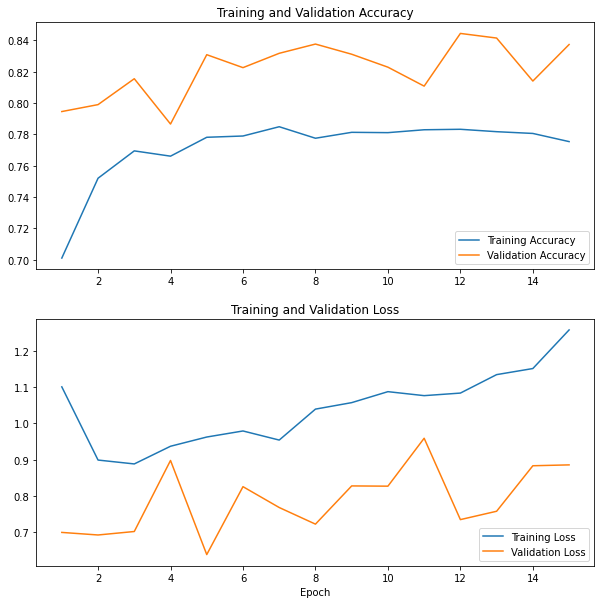

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(incp_history_frame['accuracy'], label='Training Accuracy')
plt.plot(incp_history_frame['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(incp_history_frame['loss'], label='Training Loss')
plt.plot(incp_history_frame['val_loss'], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# **Fine-Tuning**

In [ ]:
for layer in basemodel.layers:
	layer.trainable = True

In [ ]:
for idx,layer in enumerate(basemodel.layers):
  print(idx,layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fb58c6c63d0> True
1 <keras.layers.convolutional.Conv2D object at 0x7fb58c6cda50> True
2 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb58c6cded0> True
3 <keras.layers.core.activation.Activation object at 0x7fb58c6d24d0> True
4 <keras.layers.convolutional.Conv2D object at 0x7fb58c6d3750> True
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb58ca9c410> True
6 <keras.layers.core.activation.Activation object at 0x7fb58cb17f50> True
7 <keras.layers.convolutional.Conv2D object at 0x7fb58cb0e7d0> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb58d1fac10> True
9 <keras.layers.core.activation.Activation object at 0x7fb552046450> True
10 <keras.layers.pooling.MaxPooling2D object at 0x7fb552050ad0> True
11 <keras.layers.convolutional.Conv2D object at 0x7fb4f1308c10> True
12 <keras.layers.normalization.batch_normalization.BatchNormalizat

In [ ]:

for layer in basemodel.layers[:-249]:
    layer.trainable=False

for layer in basemodel.layers[-249:]:
  layer.trainable = True

Define Learning Rate

In [ ]:
def step_decay(epoch):
    initial_lr = 1e-2 
    
    if epoch < 9: 
        return initial_lr
    else: 
        return 0.00008

In [ ]:
import matplotlib.pyplot as plt                        
%matplotlib inline  

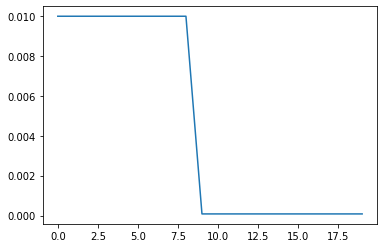

In [ ]:
x = [i for i in range(20)]
y = [step_decay(i) for i in range(20)]
plt.plot(x, y)

In [ ]:
# from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.metrics import top_k_categorical_accuracy
import math

# add LearningRateScheduler to update it
lr_scheduler = LearningRateScheduler(step_decay)

# calculate top_5_accuracy to evalute the model 
def top_5_accuracy(y_true, y_pred): 
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 10,
    restore_best_weights = True,
)

In [ ]:
from tensorflow.keras.optimizers import Adam

opt =  tensorflow.keras.optimizers.Adam(learning_rate=.0001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
BATCH_SIZE=64

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
model_file=('/content/drive/My Drive/Food-11 image dataset/MODEL_INCEPTION-V3_FT-{epoch:02d}-{val_accuracy:.2f}.hdf5')

checkpoint_ft = ModelCheckpoint(filepath=model_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_ft = [checkpoint_ft]

In [ ]:
%%time
# fine tune the already trained model
incp_ft_history = model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    # initial_epoch = initial_epoch,
    epochs = 15,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint_ft, earlystopping, anne],
    verbose=1
)

Epoch 1/15
154/154 [==============================] - ETA: 0s - loss: 1.0240 - accuracy: 0.7967
Epoch 1: val_accuracy improved from -inf to 0.86645, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_INCEPTION-V3_FT-01-0.87.hdf5
154/154 [==============================] - 304s 2s/step - loss: 1.0240 - accuracy: 0.7967 - val_loss: 0.6700 - val_accuracy: 0.8665
Epoch 2/15
154/154 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.8533
Epoch 2: val_accuracy improved from 0.86645 to 0.87824, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_INCEPTION-V3_FT-02-0.88.hdf5
154/154 [==============================] - 298s 2s/step - loss: 0.6715 - accuracy: 0.8533 - val_loss: 0.5873 - val_accuracy: 0.8782
Epoch 3/15
154/154 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.8730
Epoch 3: val_accuracy improved from 0.87824 to 0.88208, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_INCEPTION-V3_FT-03-0.

In [ ]:
incp_ft_history_frame = pd.DataFrame(incp_ft_history.history)

In [ ]:
incp_ft_history_frame.to_csv("incp_ft_history_frame.csv")
!cp incp_ft_history_frame.to_csv("incp_ft_history_frame.csv")

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp incp_ft_history_frame.to_csv("incp_ft_history_frame.csv")'


In [ ]:
incpft_history_frame = pd.read_csv("incp_ft_history_frame.csv")
incp_ft_history_frame.index = np.arange(1,16)
incp_ft_history_frame.head(2)

,loss,accuracy,val_loss,val_accuracy
1,1.023996,0.796674,0.669996,0.866450
2,0.671511,0.853295,0.587261,0.878243


In [ ]:
incp_full_history = pd.concat([incp_ft_history_frame], axis=0)

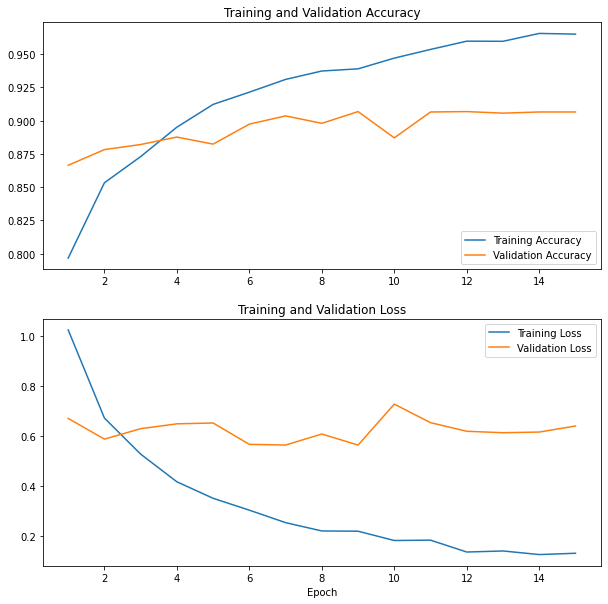

In [ ]:
acc = incp_full_history["accuracy"]
val_acc = incp_full_history['val_accuracy']

loss = incp_full_history['loss']
val_loss = incp_full_history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

### ***Combining Both ***

In [ ]:
dn_full_history = pd.concat([incp_history_frame, incp_ft_history_frame], axis=0)

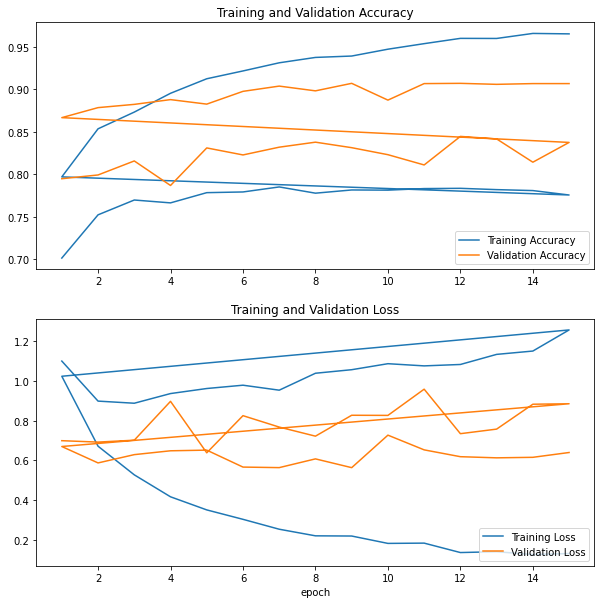

In [ ]:
acc = dn_full_history["accuracy"]
val_acc = dn_full_history['val_accuracy']

loss = dn_full_history['loss']
val_loss = dn_full_history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.plot([initial_epoch-1,initial_epoch-1],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.plot([initial_epoch-1,initial_epoch-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Evaluation of Model using Test Generator**

In [ ]:
# a function to evaluate the prediction of dataset from a given model
def model_evaluation(model, generator):
  generator.reset() # There is a reset() method for the datagenerators which resets it to the first batch. So whenever you would want to correlate the model output with the filenames you need to set shuffle as False and reset the datagenerator before performing any prediction. This will ensure that our files are being read properly and there is nothing wrong with them.

  true_classes = generator.classes
  class_indices = dict((v,k) for k,v in generator.class_indices.items())
  preds = model.predict(generator)
  preds_classes = np.argmax(preds, axis=1)
  return [true_classes, preds_classes, generator.class_indices.keys()]

In [ ]:
# for the prediction made, this function prints a confusion matrix 
def plot_confusion_matrix(true_classes, preds_classes, target_names):
  cm = confusion_matrix(true_classes, preds_classes)

  df_cm = pd.DataFrame(cm, columns=target_names, index = target_names)
  plt.figure(figsize=(12,12))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap="rocket_r") # font size , annot_kws={"size": 16}
  plt.title('Confusion Matrix\n', y=1.1)
  plt.ylabel('Actual Label\n')
  plt.xlabel('Predicted Label\n')

  plt.show()

In [ ]:
# import the metrics package for model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
result_4 =  model_evaluation(model, test_generator)
true_classes_4, preds_classes_4, target_names_4 = result_4[0], result_4[1], result_4[2]

validate_ft_acc = accuracy_score(true_classes_4, preds_classes_4) 
print("VGG16 Model WITH Fine-Tuning on Validation set has Accuracy: {:.2f}%".format(validate_ft_acc * 100))

VGG16 Model WITH Fine-Tuning on Validation set has Accuracy: 91.93%


In [ ]:
print("Classification Report of Testing Set after Fine-Tuning : ")
print(classification_report(true_classes_4, preds_classes_4,target_names =  target_names_4))

Classification report of Validation set after Fine-Tuning : 
                 precision    recall  f1-score   support

          Bread       0.92      0.83      0.87       368
  Dairy product       0.88      0.86      0.87       148
        Dessert       0.85      0.92      0.89       500
            Egg       0.87      0.90      0.89       335
     Fried food       0.86      0.93      0.89       287
           Meat       0.96      0.90      0.93       432
  Noodles-Pasta       0.99      0.99      0.99       147
           Rice       1.00      0.94      0.97        96
        Seafood       0.92      0.94      0.93       303
           Soup       0.97      0.97      0.97       500
Vegetable-Fruit       0.99      0.95      0.97       231

       accuracy                           0.92      3347
      macro avg       0.93      0.92      0.92      3347
   weighted avg       0.92      0.92      0.92      3347



Confusion Matrix of Validation set after Fine-Tuning : 


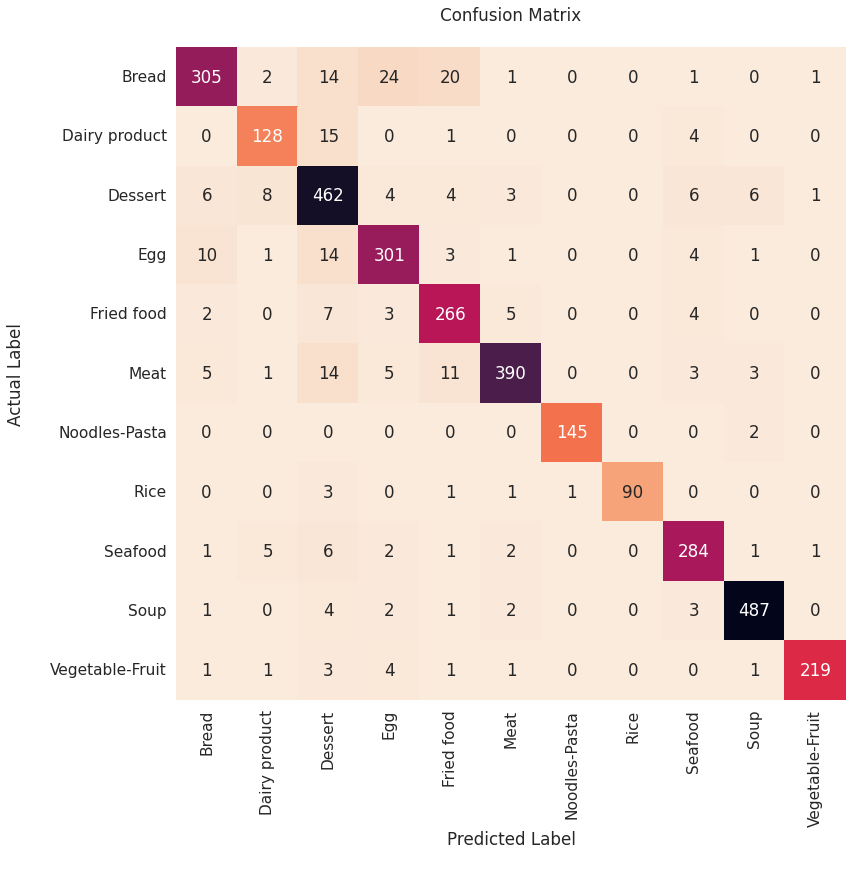

In [ ]:
print("Confusion Matrix of Validation set after Fine-Tuning : ")
plot_confusion_matrix(true_classes_4, preds_classes_4, target_names_4)